### Modelling of 2020 trips and recovery rate (slope)

1. Create a dataset for MSOA vs. Local Authority
2. Predict 2020 trips
3. Decompose recovery by LA/MSOA and calculate slope
4. Create dataset with recovery rate
5. Add features for spatial regression modelling (IMD, working population, Covid at appropriate level). 

In [1]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale
import math
from math import sqrt
import numpy as np
import random


random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

In [2]:
# Read in csv data
#tubetaps_final = pd.read_csv('output_data/tubetaps_final.csv')
pt_msoaest = pd.read_csv('output_data/pt_msoaest.csv')
covid_msoa = pd.read_csv('msoa_covidcases_2021-07-12.csv')
jobs = pd.read_csv('jobs_msoa_2011_Census.csv')
imd_msoa = pd.read_csv('imd2019_msoa_level_data.csv')
imd_la = pd.read_csv('Local_Authority_(Lower_Tier)_IMD_2019_(OSGB1936).csv') # Local Authority, no geometry
geolookup = pd.read_csv('2011_OA-LSOA-MSOA-LA.csv')

msoa_area = pd.read_csv('SAM_MSOA/SAM_MSOA_DEC_2011_EW.csv')
vehicle_owner = pd.read_csv('census_carperhousehold.csv')
income = pd.read_excel('ons-model-based-income-estimates-msoa-1.xls', sheet_name = '2015-16 (annual income)')
coviddeaths = pd.read_csv('coviddeaths_MarNov.csv')

# Shape Files
slope_msoa_mar = gpd.read_file('output_data/slope_msoa_mar.shp')
slope_msoa_jun = gpd.read_file('output_data/slope_msoa_jun.shp')
boroughs = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
imd = gpd.read_file('IMD_2019/Indices_of_Multiple_deprivation_(IMD)_2019.shp') #LSOA, smaller than MSOA
clt_msoas = gpd.read_file('clt_msoas.shp')
road_msoas = gpd.read_file('road_msoas.shp')
poi_msoas_lon = gpd.read_file('poi_msoas_greaterlondon.shp')
                         
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')
imd = imd.to_crs('epsg:27700')
clt_msoas = clt_msoas.to_crs('epsg:27700')

In [3]:
#poi = gpd.read_file('POI_GS/poi_4125257/poi_4125257.gpkg')
#poi.head()

In [4]:
# Export road_msoas
#df = poi
#df = gpd.sjoin(df, msoas, op = 'within')
#df.to_file('poi_msoas_greaterlondon.shp')

In [5]:
#poi_msoas_lon = df
#poi_msoas_lon.head()

In [6]:
#poi_msoas_lon.info()

#### Feature Creation

In [7]:
#slope_msoa = gpd.read_file('output_data/slope_msoa.shp')
slope_msoa_jun.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   region     981 non-null    object  
 1   subregion  981 non-null    object  
 2   msoa_name  981 non-null    object  
 3   msoa_code  981 non-null    object  
 4   slope      981 non-null    float64 
 5   la_name    981 non-null    object  
 6   la_code    981 non-null    object  
 7   geometry   981 non-null    geometry
dtypes: float64(1), geometry(1), object(6)
memory usage: 61.4+ KB


In [8]:
# Reduce jobs data to relevant columns, estimate percentage of homeworking of total working population
# Jobs Data: 
# Homeworking % Data:

df = jobs

df = df.rename({'geography code':'msoa_code',
'geography': 'msoa_name',                
'Occupation: All categories: Occupation; Industry: All categories: Industry; measures: Value': 'all_occupations',
'Occupation: 1. Managers, directors and senior officials; Industry: All categories: Industry; measures: Value':'managers',
'Occupation: 2. Professional occupations; Industry: All categories: Industry; measures: Value':'professional_occupations',
'Occupation: 3. Associate professional and technical occupations; Industry: All categories: Industry; measures: Value':'associate_professional',
'Occupation: 4. Administrative and secretarial occupations; Industry: All categories: Industry; measures: Value':'administrative',
'Occupation: 5. Skilled trades occupations; Industry: All categories: Industry; measures: Value':'skilled_trade',
'Occupation: 6. Caring, leisure and other service occupations; Industry: All categories: Industry; measures: Value':'caring',
'Occupation: 7. Sales and customer service occupations; Industry: All categories: Industry; measures: Value':'sales',
'Occupation: 8. Process, plant and machine operatives; Industry: All categories: Industry; measures: Value':'plant_machine',
'Occupation: 9. Elementary occupations; Industry: All categories: Industry; measures: Value':'elementary_occupations'}, axis=1)

df = df[['msoa_code',
         'msoa_name',
         'managers',
         'professional_occupations',
         'associate_professional',
         'administrative',
         'skilled_trade',
         'caring',
         'sales',
         'plant_machine',
         'elementary_occupations',
         'all_occupations']]

df['managers_hw'] = df['managers']*.67349
df['professional_occupations_hw'] = df['professional_occupations']*.69582
df['associate_professional_hw'] = df['associate_professional']*.63719
df['administrative_hw'] = df['administrative']*.57242
df['skilled_trade_hw'] = df['skilled_trade']*.18519
df['caring_hw'] = df['caring']*.14894
df['sales_hw'] = df['sales']*.15914
df['plant_machine_hw'] = df['plant_machine']*.05439
df['elementary_occupations_hw'] = df['elementary_occupations']*0

df['all_occupations_hw'] = df['managers_hw']+df['professional_occupations_hw']+df['associate_professional_hw']+df['administrative_hw']+df['skilled_trade_hw']+df['caring_hw']+df['sales_hw']+df['plant_machine_hw']+df['elementary_occupations_hw']
df['hw_pct'] = df['all_occupations_hw']/df['all_occupations']
df_avg = (df['all_occupations_hw'].agg('sum'))/(df['all_occupations'].agg('sum'))
#df['hw_pct_std'] = df['hw_pct']/df_avg
df = df[['msoa_code', 'msoa_name', 'hw_pct']]


jobs_hw = df
#jobs_hw.head()

In [9]:
# Covid Deaths by MSOA, monthly. This will capture data till end of September versus mid-September. 

#coviddeaths['coviddeaths'] = coviddeaths['April'] + coviddeaths['May'] + coviddeaths['June'] + coviddeaths['July'] + coviddeaths['August'] + coviddeaths['September']
coviddeaths['coviddeaths'] = coviddeaths['June'] + coviddeaths['July'] + coviddeaths['August'] + coviddeaths['September']
coviddeaths = coviddeaths.merge(msoas, how = 'left', left_on ='MSOA code', right_on = 'MSOA11CD')
coviddeaths['coviddeaths_den'] = coviddeaths['coviddeaths']/coviddeaths['POPDEN']

coviddeaths = coviddeaths[['MSOA code','coviddeaths','coviddeaths_den']]


#coviddeaths.head()

In [10]:
# Cycling data, load in MSOAs by Hectare to normalise the metres of cycle paths versus area of MSOA. 

clt_msoas_dropgeo = clt_msoas[['msoa11cd', 'length']]
clt_msoas_dropgeo = clt_msoas_dropgeo.merge(msoa_area, left_on = 'msoa11cd', right_on = 'MSOA11CD')
clt_msoas_dropgeo['cyclelength_perhect'] = clt_msoas_dropgeo['length']/clt_msoas_dropgeo['AREAEHECT']

#clt_msoas_dropgeo.head()

In [11]:
# Road data

#df = road
#df = gpd.sjoin(df, msoas, op = 'within')
#df.head()
#road_msoas = df

In [12]:
# Export road_msoas

#road_msoas.to_file('road_msoas.shp')

In [13]:
# Calculate road length per hectacre

df = road_msoas
df = df.groupby(['MSOA11CD', 'MSOA11NM', ])['length'].agg('sum').reset_index()
df = df.merge(msoa_area, left_on = ['MSOA11NM','MSOA11CD'], right_on = ['MSOA11NM','MSOA11CD'])
df['roadlength_perhect'] = df['length']/df['AREAEHECT']
road_length = df

In [14]:
# Count the following locations
# 1. category name = Bus Transport, classname = Bus Stops
# 2. category name = 'Public Transport, Stations and Infrastructure', may be collinear with number_tubestations
# 3. category name = Primary, Secondary and Tertiary Education
# 4. category name = 'Recreational'

df = poi_msoas_lon
df_poi = poi_msoas_lon[['MSOA11CD']].drop_duplicates()

df_education = df[df['categoryna']=='Primary, Secondary and Tertiary Education'].groupby(['MSOA11CD']).agg({'categoryna':'count'}).reset_index()
df_education = df_education.rename({'categoryna':'education_cnt'}, axis = 1)

#df_busstops = df[(df['categoryna']=='Bus Transport')&(df['classname']=='Bus Stops')].groupby(['MSOA11CD']).agg({'categoryna':'count'}).reset_index()
#df_busstops = df_busstops.rename({'categoryna':'busstops_cnt'}, axis = 1)

df_pubtrans = df[(df['categoryna']=='Public Transport, Stations and Infrastructure')|((df['categoryna']=='Bus Transport')&(df['classname']=='Bus Stops'))].groupby(['MSOA11CD']).agg({'categoryna':'count'}).reset_index()
df_pubtrans = df_pubtrans.rename({'categoryna':'pubtrans_cnt'}, axis = 1)

df_recreation = df[df['categoryna']=='Recreational'].groupby(['MSOA11CD']).agg({'categoryna':'count'}).reset_index()
df_recreation = df_recreation.rename({'categoryna':'recreation_cnt'},axis = 1)

df_poi = df_poi.merge(df_education, how = 'left', left_on = 'MSOA11CD', right_on = 'MSOA11CD')
#df_poi = df_poi.merge(df_busstops, how = 'left', left_on = 'MSOA11CD', right_on = 'MSOA11CD')
df_poi = df_poi.merge(df_pubtrans, how = 'left', left_on = 'MSOA11CD', right_on = 'MSOA11CD')
df_poi = df_poi.merge(df_recreation, how = 'left', left_on = 'MSOA11CD', right_on = 'MSOA11CD')

df_poi = df_poi.merge(msoas, how = 'left', left_on ='MSOA11CD', right_on = 'MSOA11CD')
df_poi['education_den'] = df_poi['education_cnt']/df_poi['POPDEN']
#df_poi['busstops_den'] = df_poi['busstops_cnt']/df_poi['POPDEN']
df_poi['pubtrans_den'] = df_poi['pubtrans_cnt']/df_poi['POPDEN']
df_poi['recreation_den'] = df_poi['recreation_cnt']/df_poi['POPDEN']

df_poi = df_poi[['MSOA11CD','education_cnt','pubtrans_cnt','recreation_cnt','education_den','pubtrans_den','recreation_den']]

#df_poi.head()

In [15]:
# Trip density based on 2019's distribution
pt_df = pt_msoaest
pt_df = pt_df[(pt_df['week_beg']>='2019-06-08')&(pt_df['week_beg']<='2019-09-07')]
pt_df = pt_df.groupby('msoa_code')['origin_trips'].agg('sum').reset_index()
pt_df = pt_df.merge(msoa_area, left_on = 'msoa_code', right_on = 'MSOA11CD')
pt_df['trips_perhect'] = pt_df['origin_trips']/pt_df['AREAEHECT']
#pt_df

In [16]:
# Greenspace

#grnspace = gpd.read_file('POI_GS/open-greenspace_4125256/opgrsp_gb.gpkg')
#grnspace.head()

In [17]:
#df = grnspace[grnspace['accessType']=='Pedestrian']

#df = gpd.sjoin(df, msoas, op = 'within')
#grnspace_msoas = df
#grnspace_msoas.to_file('grnspace_msoas.shp')

In [18]:
#grnspace_msoas

In [19]:
# Create feature dataset for analysis
# Per this resource, variables will be standardised by subtracting the mean
# https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

df = slope_msoa_mar

#df2 = rail_msoaest

# Merge against MSOAs to get population count
msoas_dropgeo = msoas[['MSOA11CD', 'USUALRES']]
df = df.merge(msoas_dropgeo, left_on = 'msoa_code', right_on = 'MSOA11CD')


# IMD
df = df.merge(imd_msoa, left_on = 'msoa_code', right_on = 'MSOAC')
df['imd_std'] = df['IMD19 SCORE'] - (df['IMD19 SCORE'].agg('mean'))

# Homeworking %
df = df.merge(jobs_hw, left_on = ['msoa_code', 'msoa_name'], right_on = ['msoa_code', 'msoa_name'])

# Covid Cases
df = df.merge(coviddeaths, how = 'left', left_on = 'msoa_code', right_on = 'MSOA code')

#df['coviddeaths_marsep_pp'] = df['coviddeaths_marsep']/df['USUALRES']


# Cycle metres by MSOA
df = df.merge(clt_msoas_dropgeo, how = 'left', left_on = 'msoa_code', right_on = 'msoa11cd')

#df['cyclelength_pp'] = df['length']/df['USUALRES']


# Income by MSOA
income_msoa = income[['MSOA code', 'Total annual income (£)']]
df = df.merge(income, left_on = 'msoa_code', right_on = 'MSOA code')


# POI: Education, Public Transport Infra
df = df.merge(df_poi, left_on = 'msoa_code', right_on = 'MSOA11CD')

# Trip density
df = df.merge(pt_df, left_on = 'msoa_code', right_on = 'msoa_code')

# Vehicle Ownership
df = df.merge(vehicle_owner, left_on = 'msoa_code', right_on = 'MSOA Code')

# Road Length
df = df.merge(road_length, left_on = ['msoa_code', 'msoa_name'], right_on = ['MSOA11CD','MSOA11NM'] )

# log slope
df['log_slope'] = np.log(df['slope'])

df = df.rename({'IMD19 SCORE':'imd_score',
                'Total annual income (£)': 'total_income',
                'Cars per household': 'cars_per_hhld'}, axis=1)

df = df[['msoa_name',
         'msoa_code',
         'la_name',
         'la_code',
         'region',
         'subregion',
         'slope',
         'log_slope',
         'geometry',
         'imd_score',
         'total_income',
         'hw_pct',
         'cyclelength_perhect',
         'cars_per_hhld',
         'roadlength_perhect',
         'trips_perhect',        
         'education_cnt',
         #'busstops_cnt',
         'pubtrans_cnt',
         'recreation_cnt',
         'education_den',
         #'busstops_den',
         'pubtrans_den',
         'recreation_den',
         'coviddeaths',
         'coviddeaths_den'
         ]]

#slope_msoa = df
#slope_msoa.head()
#df.head()
print(len(df.index))

981


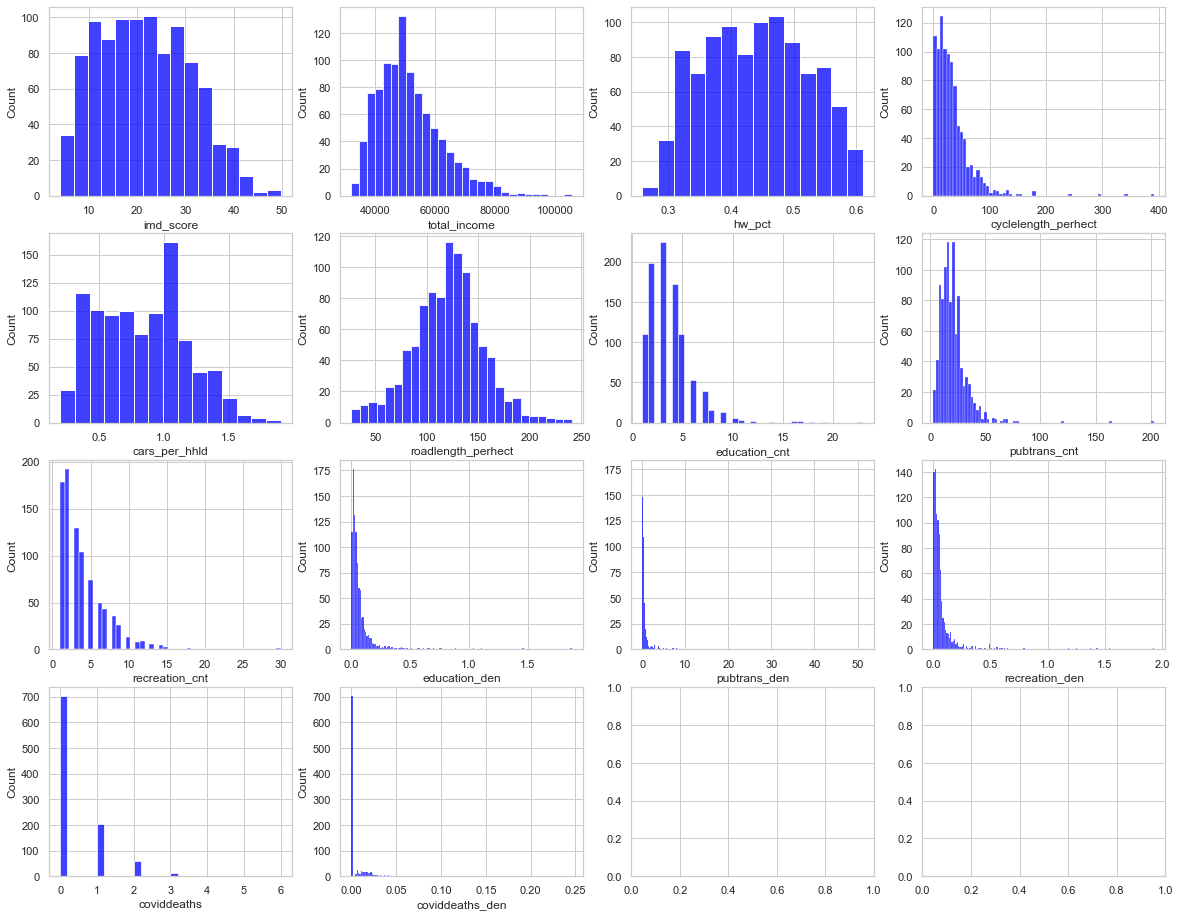

In [20]:
f, ax = plt.subplots(4,4, figsize=(20, 16))

#df = slope_msoa
#df = df[(df['cyclelength_perhect_std']<200)&(df['pubtrans_cnt_std']<30)&(df['busstops_cnt_std']<75)]

plt_cols = ['imd_score',
         'total_income',
         'hw_pct',
         'cyclelength_perhect',
         'cars_per_hhld',
         'roadlength_perhect',        
         'education_cnt',
         #'busstops_cnt',
         'pubtrans_cnt',
         'recreation_cnt',
         'education_den',
         #'busstops_den',
         'pubtrans_den',
         'recreation_den',
         'coviddeaths',
         'coviddeaths_den']

k = 0

for i in range(0, 4):
    for j in range(0, 4):
        if k <= (len(plt_cols)-1):
            #print(plt_cols[k])
            sns.histplot(x=plt_cols[k], data = df, ax=ax[i,j], color = 'blue')
            k = k+1

In [21]:
# Log

log_cols = [
         'cyclelength_perhect',
         'trips_perhect',        
         'education_cnt',
         #'busstops_cnt',
         'pubtrans_cnt',
         'recreation_cnt',
         'education_den',
         #'busstops_den',
         'pubtrans_den',
         'recreation_den',
         'coviddeaths',
         'coviddeaths_den']


#df = slope_msoa

for i in range(0, len(log_cols)):
    print(log_cols[i])
    df[str(f"log_{log_cols[i]}")] = np.log(df[log_cols[i]])    

cyclelength_perhect
trips_perhect
education_cnt
pubtrans_cnt
recreation_cnt
education_den
pubtrans_den
recreation_den
coviddeaths
coviddeaths_den


C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
df[df['coviddeaths']>0][['msoa_name', 'coviddeaths', 'coviddeaths_den', 'log_coviddeaths', 'log_coviddeaths_den']]

,msoa_name,coviddeaths,coviddeaths_den,log_coviddeaths,log_coviddeaths_den
0,Hackney 001,1,0.01,0.00,-4.97
3,Hackney 004,1,0.01,0.00,-4.98
6,Hackney 008,1,0.01,0.00,-4.50
21,Hackney 023,1,0.01,0.00,-4.88
22,Hackney 024,2,0.01,0.69,-4.33
...,...,...,...,...,...
968,Richmond upon Thames 011,1,0.02,0.00,-3.81
972,Richmond upon Thames 015,1,0.02,0.00,-3.76
976,Richmond upon Thames 019,1,0.02,0.00,-3.84
978,Richmond upon Thames 021,1,0.05,0.00,-2.94


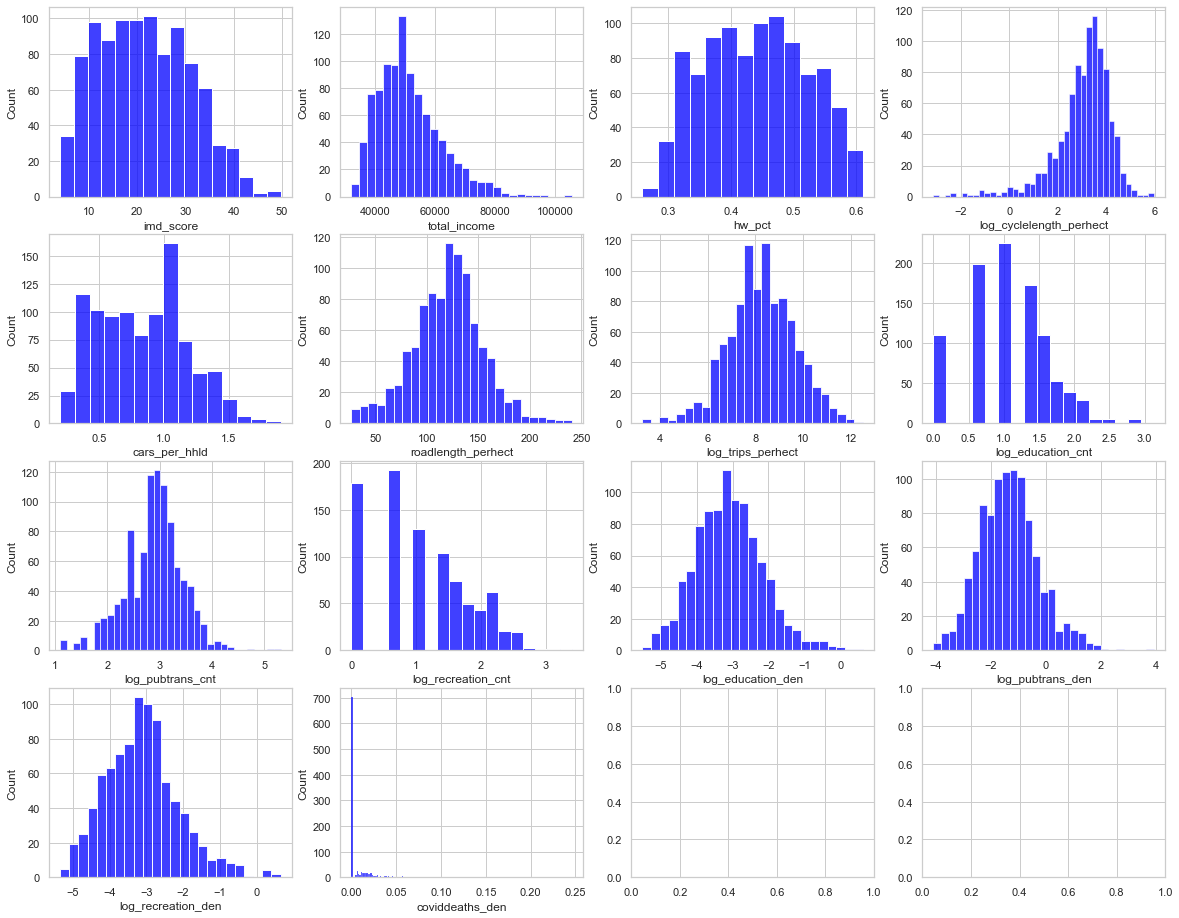

In [23]:
f, ax = plt.subplots(4,4, figsize=(20, 16))

#df = slope_msoa
#df = df[(df['cyclelength_perhect_std']<200)&(df['pubtrans_cnt_std']<30)&(df['busstops_cnt_std']<75)]

plt_cols = ['imd_score',
         'total_income',
         'hw_pct',
         'log_cyclelength_perhect',
         'cars_per_hhld',
         'roadlength_perhect',
         'log_trips_perhect',        
         'log_education_cnt',
         #'log_busstops_cnt',
         'log_pubtrans_cnt',
         'log_recreation_cnt',
         'log_education_den',
         #'log_busstops_den',
         'log_pubtrans_den',
         'log_recreation_den',
         'coviddeaths_den']

k = 0

for i in range(0, 4):
    for j in range(0, 4):
        if k <= (len(plt_cols)-1):
            #print(plt_cols[k])
            sns.histplot(x=plt_cols[k], data = df, ax=ax[i,j], color = 'blue')
            k = k+1

In [24]:
# Standardise variables

std_cols = ['slope',
         'imd_score',
         'total_income',
         'hw_pct',
         'cyclelength_perhect',
         'log_cyclelength_perhect',
         'cars_per_hhld',
         'roadlength_perhect',
         'trips_perhect', 
         'log_trips_perhect',
         'education_cnt',
         'log_education_cnt',
         'education_den',
         'log_education_den',
         #'busstops_cnt',
         #'log_busstops_cnt',
         #'busstops_den',
         #'log_busstops_den',
         'pubtrans_cnt',
         'log_pubtrans_cnt',
         'pubtrans_den',
         'log_pubtrans_den',
         'recreation_cnt',
         'log_recreation_cnt',
         'recreation_den',         
         'log_recreation_den',
         'coviddeaths',
         'coviddeaths_den',
         'log_coviddeaths_den']


#df = slope_msoa

for i in range(0, len(std_cols)):
    #print(i)
    #df[std_cols[i]] = df[std_cols[i]].fillna(0)
    df[str(f"{std_cols[i]}_std")] = (df[std_cols[i]] - df[std_cols[i]].mean())/df[std_cols[i]].std()
    #df[str(f"{std_cols[i]}_std2")] = df[std_cols[i]]/df[std_cols[i]].agg('mean')

    
#slope_msoa = df

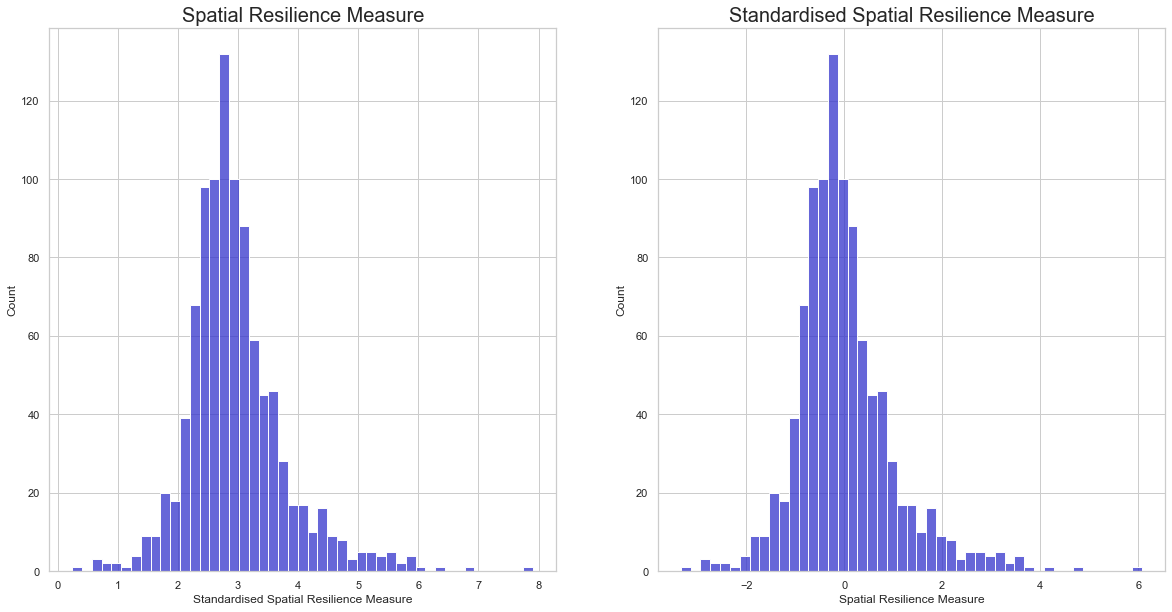

In [38]:
# Checking if logging changes the distribution, significantly. not so much, so analysis can stay with
# normal variable, it may instead be better to consider removing outliers.

sns.set_context('notebook')
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)

#df = slope_msoa

p = sns.histplot(data=df, x='slope', color = '#3333CC', ax=ax[0])
q = sns.histplot(data=df, x='slope_std', color = '#3333CC', ax=ax[1])
p.set_title("Spatial Resilience Measure", fontsize = 20)
q.set_title("Standardised Spatial Resilience Measure", fontsize = 20)
q.set_xlabel("Spatial Resilience Measure", fontsize = 12)
p.set_xlabel("Standardised Spatial Resilience Measure", fontsize = 12)

plt.savefig('plots/srm_standardised.png')

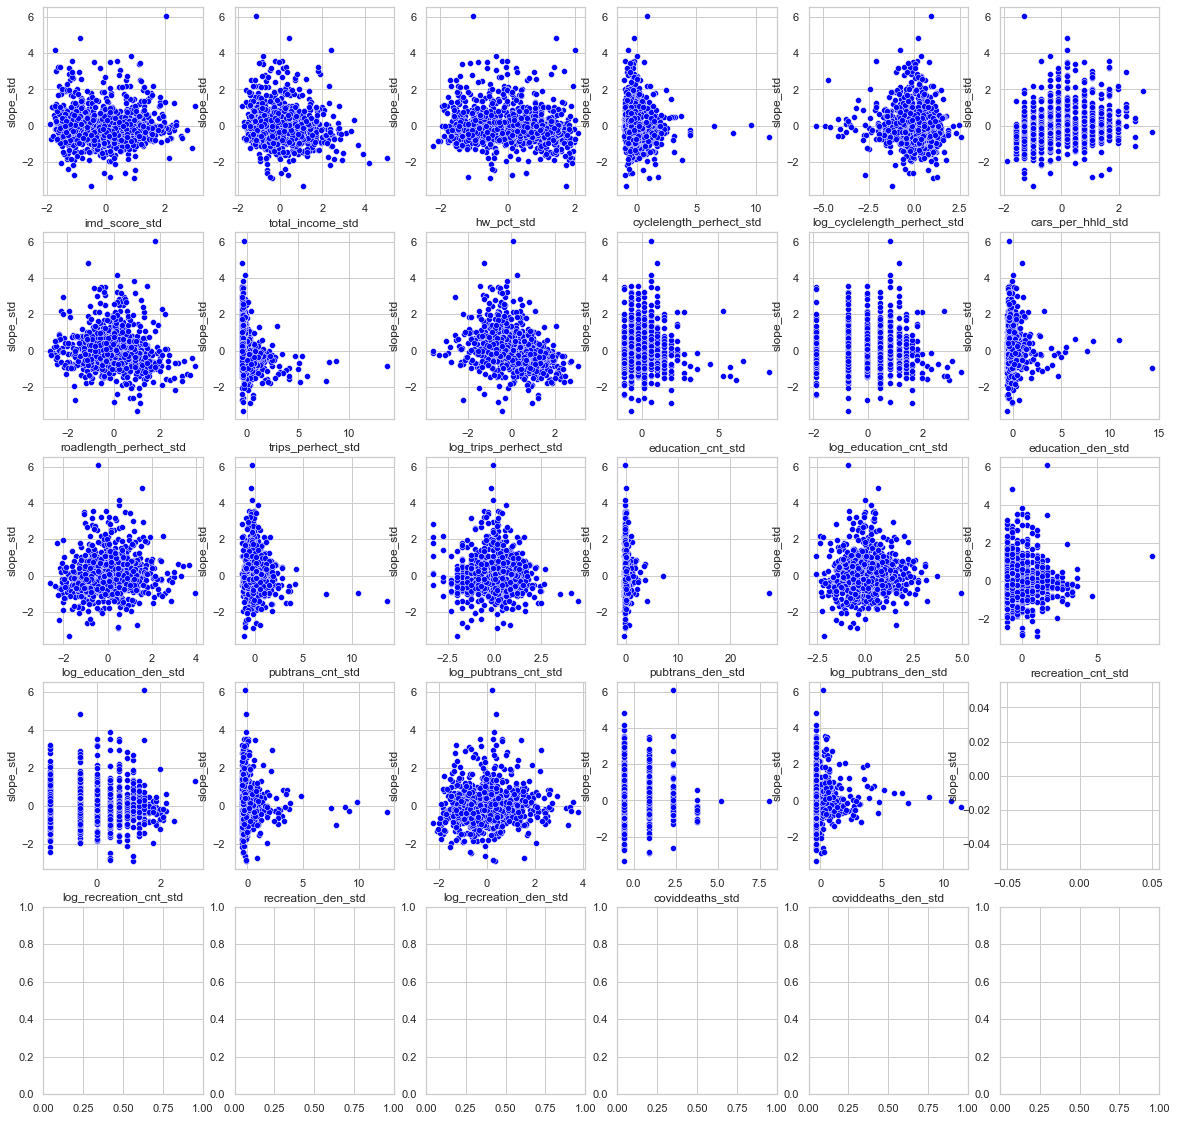

In [26]:
f, ax = plt.subplots(5,6, figsize=(20, 20))

#df = slope_msoa
#df = df[(df['cyclelength_perhect_std']<200)&(df['pubtrans_cnt_std']<30)&(df['busstops_cnt_std']<75)]

plt_cols = ['imd_score_std',
         'total_income_std',
         'hw_pct_std',
         'cyclelength_perhect_std',
         'log_cyclelength_perhect_std',
         'cars_per_hhld_std',
         'roadlength_perhect_std',
         'trips_perhect_std', 
         'log_trips_perhect_std',
         'education_cnt_std',
         'log_education_cnt_std',
         'education_den_std',
         'log_education_den_std',
         #'busstops_cnt_std',
         #'log_busstops_cnt_std',
         #'busstops_den_std',
         #'log_busstops_den_std',
         'pubtrans_cnt_std',
         'log_pubtrans_cnt_std',
         'pubtrans_den_std',
         'log_pubtrans_den_std',
         'recreation_cnt_std',
         'log_recreation_cnt_std',
         'recreation_den_std',         
         'log_recreation_den_std',
         'coviddeaths_std',
         'coviddeaths_den_std',
         'log_coviddeaths_den_std']

k = 0

for i in range(0, 5):
    for j in range(0, 6):
        if k <= (len(plt_cols)-1):
            #print(plt_cols[k])
            sns.scatterplot(x=plt_cols[k], y='slope_std', data = df, ax=ax[i,j], color = 'blue')
            k = k+1


In [27]:
df[['slope_std', 'log_slope', 'total_income', 'total_income_std', 'pubtrans_den', 'pubtrans_den_std', 'cars_per_hhld_std']].describe()

,slope_std,log_slope,total_income,total_income_std,pubtrans_den,pubtrans_den_std,cars_per_hhld_std
count,981.00,981.00,981.00,981.00,981.00,981.00,981.00
mean,0.00,1.05,"51,386.95",-0.00,0.55,0.00,0.00
std,1.00,0.28,"10,776.40",1.00,1.85,1.00,1.00
min,-3.34,-1.43,"32,000.00",-1.80,0.02,-0.29,-1.90
25%,-0.58,0.91,"43,700.00",-0.71,0.12,-0.23,-1.00
50%,-0.16,1.04,"49,400.00",-0.18,0.25,-0.16,-0.11
75%,0.41,1.19,"57,200.00",0.54,0.49,-0.03,0.78
max,6.08,2.07,"105,700.00",5.04,51.25,27.45,3.16


<AxesSubplot:xlabel='log_pubtrans_den_std', ylabel='slope'>

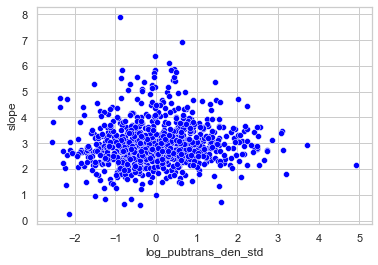

In [28]:
sns.scatterplot(x='log_pubtrans_den_std', y='slope', data = df, color = 'blue')

In [29]:
df[['log_slope','log_pubtrans_den_std']].corr()

,log_slope,log_pubtrans_den_std
log_slope,1.00,0.11
log_pubtrans_den_std,0.11,1.00


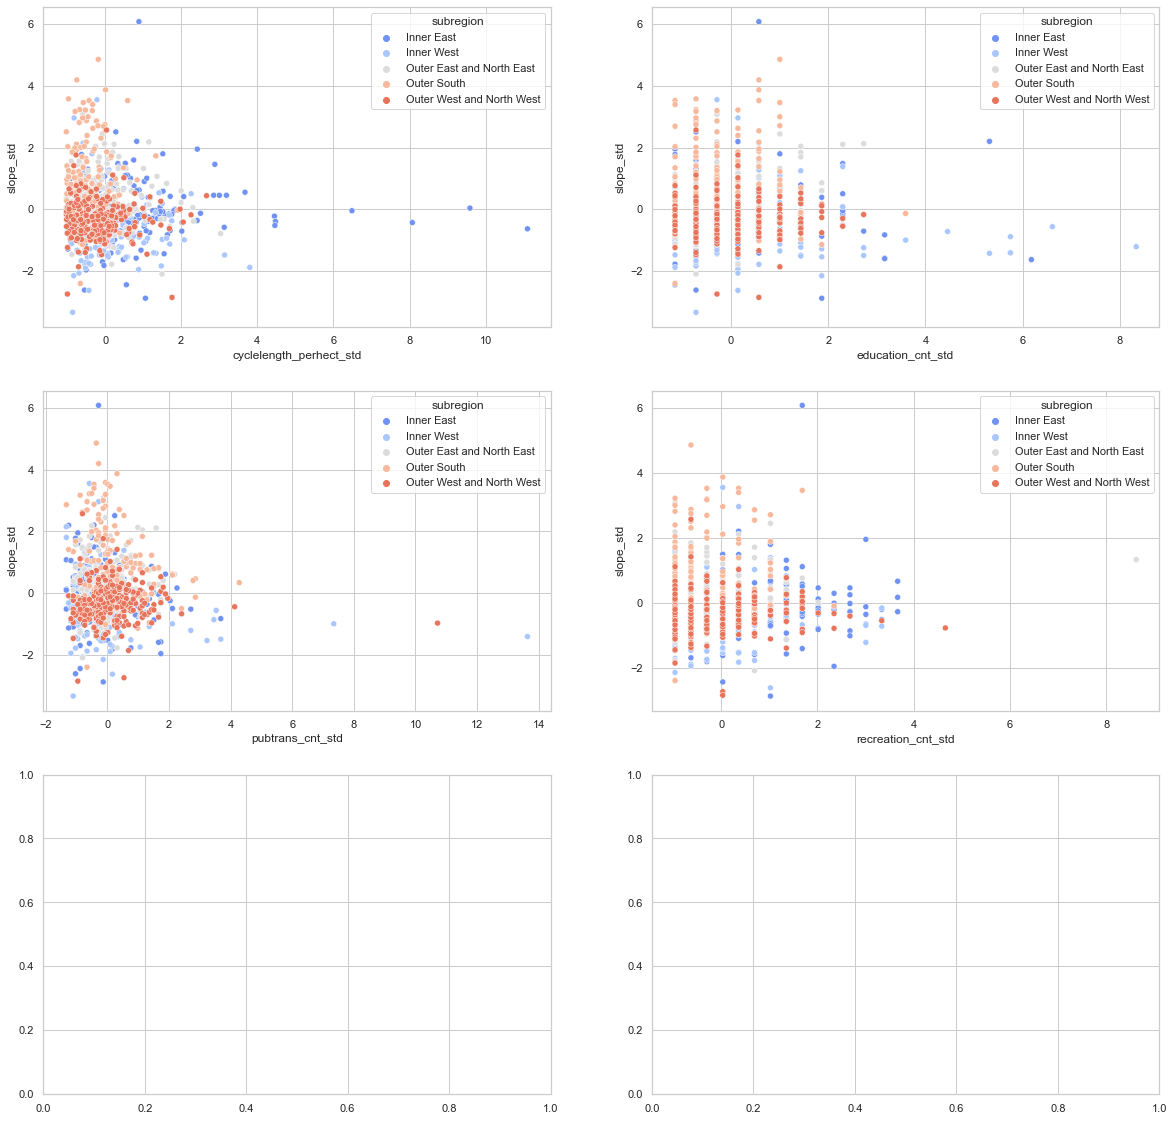

In [30]:
# Plot to justify keeping outliers in
f, ax = plt.subplots(3,2, figsize=(20, 20))

#df = slope_msoa
#df = df[(df['cyclelength_perhect_std']<200)&(df['pubtrans_cnt_std']<30)&(df['busstops_cnt_std']<75)]

plt_cols = ['cyclelength_perhect_std',
            'education_cnt_std',
            #'busstops_cnt_std',
            'pubtrans_cnt_std',
            'recreation_cnt_std'           
           ]

k = 0

for i in range(0, 3):
    for j in range(0, 2):
        if k <= (len(plt_cols)-1):
            #print(plt_cols[k])
            sns.scatterplot(x=plt_cols[k], y='slope_std', data = df, ax=ax[i,j], hue='subregion', palette = 'coolwarm')
            k = k+1


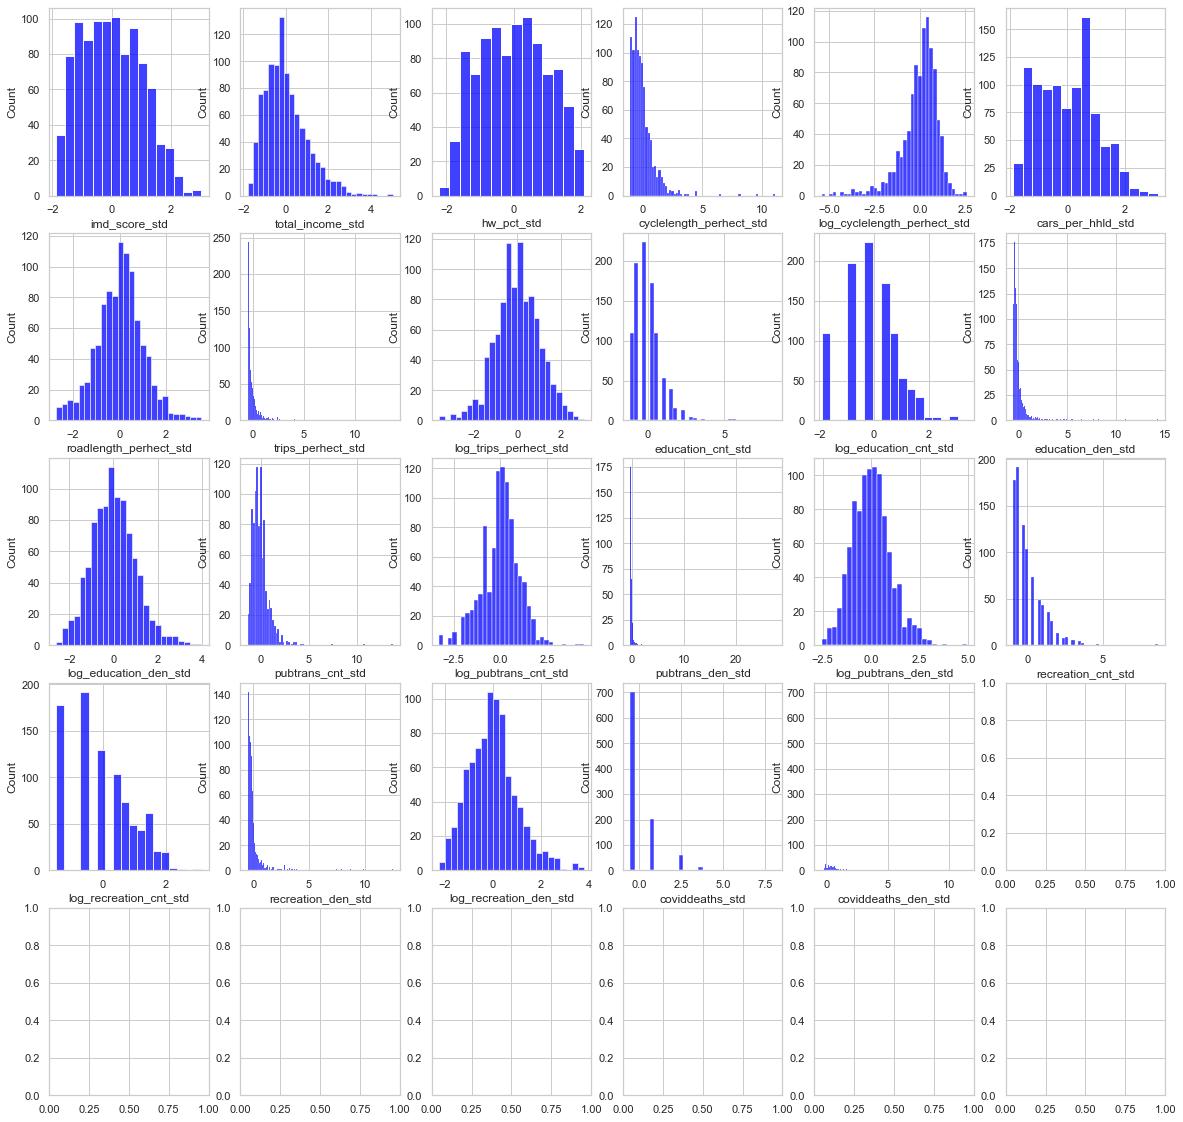

In [31]:
f, ax = plt.subplots(5,6, figsize=(20, 20))

#df = slope_msoa
#df = df[(df['cyclelength_perhect_std']<200)&(df['pubtrans_cnt_std']<30)&(df['busstops_cnt_std']<75)]

plt_cols = ['imd_score_std',
         'total_income_std',
         'hw_pct_std',
         'cyclelength_perhect_std',
         'log_cyclelength_perhect_std',
         'cars_per_hhld_std',
         'roadlength_perhect_std',
         'trips_perhect_std', 
         'log_trips_perhect_std',
         'education_cnt_std',
         'log_education_cnt_std',
         'education_den_std',
         'log_education_den_std',
         #'busstops_cnt_std',
         #'log_busstops_cnt_std',
         #'busstops_den_std',
         #'log_busstops_den_std',
         'pubtrans_cnt_std',
         'log_pubtrans_cnt_std',
         'pubtrans_den_std',
         'log_pubtrans_den_std',
         'recreation_cnt_std',
         'log_recreation_cnt_std',
         'recreation_den_std',         
         'log_recreation_den_std',
         'coviddeaths_std',
         'coviddeaths_den_std',
         'log_coviddeaths_den_std']

k = 0

for i in range(0, 5):
    for j in range(0, 6):
        if k <= (len(plt_cols)-1):
            #print(plt_cols[k])
            sns.histplot(x=plt_cols[k], data = df, ax=ax[i,j], color = 'blue')
            k = k+1

In [32]:
# Name dataframe
spatial_recovery_jun = df

In [33]:
# For loop of Tukey Test to identify outliers

cols = [#'imd_score_std',
         #'total_income_std',
         #'hw_pct_std',
         'cyclelength_perhect_std',
         #'log_cyclelength_perhect_std',
         #'cars_per_hhld_std',
         #'roadlength_perhect_std',
         #'trips_perhect_std', 
         #'log_trips_perhect_std',
         'education_cnt_std',
         #'log_education_cnt_std',
         #'education_den_std',
         #'log_education_den_std',
         #'busstops_cnt_std',
         #'log_busstops_cnt_std',
         #'busstops_den_std',
        #'log_busstops_den_std',
         'pubtrans_cnt_std',
         #'log_pubtrans_cnt_std',
         #'pubtrans_den_std',
         #'log_pubtrans_den_std',
         'recreation_cnt_std']#,
         #'log_recreation_cnt_std',
         #'recreation_den_std',         
         #'log_recreation_den_std',
         #'coviddeaths_std']

outliers = pd.DataFrame()

for i in range(0, len(cols)):
    print(cols[i])
    IQR = df[cols[i]].quantile(0.75) - df[cols[i]].quantile(0.25)
    low = df[cols[i]].quantile(0.25) - 5*IQR
    high = df[cols[i]].quantile(0.75) + 5*IQR
    outlier_low = df[df[cols[i]] < low]
    outlier_high = outlier_low.append(df[df[cols[i]] > high])
    outlier_high['outlying_variable'] = cols[i]
    outliers = outliers.append(outlier_high)
    #outliers = pd.concat([outlier_low, outlier_high])
    #df_final = df.drop(outliers.index)
    #outliers_df = outliers_df.append(outliers)
    


#outliers
outliers[['msoa_name','outlying_variable', 'cyclelength_perhect_std']]
#msoa_outliers = outliers[['msoa_name']].drop_duplicates()
#msoa_outliers = msoa_outliers.reset_index()
#msoa_outliers = list(msoa_outliers['msoa_name'])
#msoa_outliers

cyclelength_perhect_std
education_cnt_std
pubtrans_cnt_std
recreation_cnt_std


,msoa_name,outlying_variable,cyclelength_perhect_std
16,Hackney 018,cyclelength_perhect_std,9.59
20,Hackney 022,cyclelength_perhect_std,11.10
227,Tower Hamlets 001,cyclelength_perhect_std,6.49
229,Tower Hamlets 003,cyclelength_perhect_std,8.07
286,Camden 028,education_cnt_std,0.36
287,City of London 001,pubtrans_cnt_std,1.28
388,Westminster 018,pubtrans_cnt_std,-0.23
928,Hillingdon 031,pubtrans_cnt_std,-0.62
414,Barking and Dagenham 021,recreation_cnt_std,0.55


In [34]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 981 entries, 0 to 980
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   msoa_name                    981 non-null    object  
 1   msoa_code                    981 non-null    object  
 2   la_name                      981 non-null    object  
 3   la_code                      981 non-null    object  
 4   region                       981 non-null    object  
 5   subregion                    981 non-null    object  
 6   slope                        981 non-null    float64 
 7   log_slope                    981 non-null    float64 
 8   geometry                     981 non-null    geometry
 9   imd_score                    981 non-null    float64 
 10  total_income                 981 non-null    int64   
 11  hw_pct                       981 non-null    float64 
 12  cyclelength_perhect          965 non-null    float64 
 1

In [35]:
# Save as Shape File

#spatial_recovery_jun.to_file('output_data/spatial_recovery_junpub.shp')

In [36]:
# Unused Code

# Scale variables that appear to have outliers we don't like so much.
# Attempted to scale as an alternative to logging variables, but it doesn't seem to make an impact.

#scl_cols = ['cyclelength_perhect_std',
#           'trips_perhect_std', 
#           'education_cnt_std',
#           'busstops_cnt_std',
#           'pubtrans_cnt_std',
#           'recreation_cnt_std',
#           'education_den_std',
#           'busstops_den_std',
#           'pubtrans_den_std',
#           'recreation_den_std']


#df = slope_msoa

#for i in range(0, len(scl_cols)):
    #print(i)
#    df[str(f"{scl_cols[i]}_scl")] = robust_scale(df[scl_cols[i]])

    
#slope_msoa = df

# OLS model for all variables, none of the variables are significant in this case. Excluding potential outliers.

#df = spatial_recovery
#df = df[(df['cyclelength_perhect_std']<200)&(df['pubtrans_cnt_std']<30)&(df['busstops_cnt_std']<75)]

#model = sm.formula.ols('slope ~ imd_score_std + cyclelength_perhect_std + hw_pct_std + coviddeaths_marsep_std + total_income_std + education_cnt_std + busstops_cnt_std + pubtrans_cnt_std + recreation_cnt_std + cars_per_hhld_std + roadlength_perhect_std', data = df).fit()
#model.summary()

#df = spatial_recovery

#model_log = sm.formula.ols('slope ~ imd_score_std + log_cyclelength_std + hw_pct_std + coviddeaths_marsep_std + total_income_std + log_education_std + log_busstops_std + log_pubtrans_std + log_recreation_std + cars_per_hhld_std + roadlength_perhect_std', data = df).fit()
#model_log.summary()

#df = slope_msoa[slope_msoa['slope']<.006]

#predictions = model.get_prediction(df)
#predictions_summary_frame = predictions.summary_frame()
    

# for some reason, we need to specify the rows as the values are being inserted randomly otherwise 
# but, the errors indicate python does not like this.
#df['estimate'] = predictions_summary_frame['mean']
#df['residuals'] = df['estimate'] - df['slope']

# Plotting of residuals against existing model, not forecasted values.
#fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)


#sns.scatterplot(x = "estimate", y = "residuals", data = df, ax=ax[0])#, hue = 'number_pubtrans')
#ax[0].axhline(y=0, color='r', ls='--')

#sns.histplot(data=df, x='residuals')
#ax[0].set_title('Residuals: Scatterplot', fontsize = 16)
#ax[1].set_title('Residuals: Histogram', fontsize = 16)
#ax[1].set_ylim(0,200)

# Get Covid rates for MSOAs in September, pull the maximum date available by end-September
# These rolling rates are likely only over 7 days, ideally, we want data showing number of cases by MSOA and calculate our own rate

#df = covid_msoa
#df['date'] = pd.to_datetime(df['date'])
#df = df[df['date']<='9/30/2020']
#df = df.groupby(['areaCode', 'areaName']).agg({'date':'max'})
#df = pd.DataFrame(df)
#df = df.reset_index()
#df = df.merge(covid_msoa, left_on = ['areaCode', 'areaName', 'date'], right_on = ['areaCode', 'areaName', 'date'])
#df = df.rename({'areaCode':'msoa_code',
#                'areaName':'msoa_name',
#                'newCasesBySpecimenDateRollingRate':'covidcases_rolling'}, axis = 1)

#df = df[['msoa_code', 'date', 'covidcases_rolling']]
#df
#covid_msoa_sep = df